# 📌 <span style="font-size:18px; color:#007acc;"><b>Introduction</b></span>

This notebook demonstrates a modular pipeline for loan delinquency prediction using data from Freddie Mac. It includes well-structured functions for data loading, merging, handling missing values through mask generation, applying scalable unsupervised outlier detection techniques and EDA. All processing functions are defined before execution, with external variables managed via a YAML configuration file to ensure flexibility and reproducibility. As the workflow was developed on Microsoft Azure, certain settings may need to be adjusted when running the notebook in a different environment. The dataset was obtained from **[Freddie Mac](https://www.freddiemac.com/)**. 

<span style="font-size:18px; color:#e63946;"><b>


# <span style="font-size:18px; color:#007acc;"><b> Table of Contents</b></span>
1. [Install libraries](#Install-Libraries)
2. [Import modules](#Import-Modules) 
3. [Functions for data pre-processing](#Functions-for-data-pre-processing)  
4. [Main execution code for pre-processing](#Main-execution-code-for-pre-processing)  


## <span style="font-size:18px; color:#007acc;"><b> 1. Install libraries <a id="Install-Libraries"></a> ##

In [ ]:
# Required libraries to be installed
!pip install numpy 
!pip install pandas
!pip install pyod  # PyOD for anomaly detection (outlier detection algorithms)
!pip install seaborn 
!pip install category_encoders  # Category Encoders for transforming categorical data into numeric
!pip install suod  # SUOD for scalable unsupervised outlier detection (for large datasets)
!pip install openpyxl
!pip install matplotlib
!pip install azureml-core  # AzureML Core for interacting with Azure Machine Learning services
!pip install azure-storage-blob  # Azure Storage Blob for managing files in Azure Blob Storage
!pip install azureml-dataset-runtime  # AzureML Dataset Runtime for working with datasets in Azure ML

## <span style="font-size:18px; color:#007acc;"><b> 2. Import modules <a id="Import-modules"></a> ##

In [3]:
# Standard library imports
import glob
import logging
import os
from io import BytesIO

# Third-party imports
import category_encoders as ce
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyod
import scipy
import seaborn as sns
import sklearn
import yaml
from azure.storage.blob import BlobServiceClient
from pyod.models.hbos import HBOS
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.ocsvm import OCSVM
from pyod.models.iforest import IForest
from sklearn.decomposition import PCA
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import (
    LabelEncoder,
    MinMaxScaler,
    Normalizer,
    OneHotEncoder,
    RobustScaler,
    StandardScaler,
)
from suod.models.base import SUOD

2025-04-11 19:29:17,457 - INFO - NumExpr defaulting to 4 threads.


## <span style="font-size:18px; color:#007acc;"><b> 3. Functions for data pre-processing <a id="Functions for data-preprocessing"></a> ##

In [4]:
"""
The workflow includes the following key steps:

1. **Load Configuration**: The configuration settings (file paths, column names, etc.) are loaded from a YAML configuration file (`config.yaml`).
2. **Connect to Azure Blob Storage**: A connection to Azure Blob Storage is established using the provided configuration.
3. **Merge Data**: Loan origination and performance data are read from Azure Blob Storage and merged into a single dataset.
4. **Data Processing**:
   - **Missing Values Detection**: Identify missing values using a custom mask and visualize missing data before and after cleaning.
   - **Missing Values Handling**: Columns with missing data are cleaned based on a mask, and the cleaning process is applied.
   - **One-Hot Encoding**: Categorical variables are one-hot encoded for model readiness.
   - **Outlier Detection and Removal**: Outliers in the dataset are detected, followed by outlier removal.
5. **Anomaly Detection**: Anomaly detection columns are normalized using MinMax scaling.
6. **Feature and Label Separation**: Features and labels are separated for model training. The label column (`Current loan delinquency status`) is flipped (0 → 1, 1 → 0).
7. **Data Export**: Features and labels are exported to Excel files for further use or modeling.

Functions included:
- `load_config()`: Loads the configuration from a YAML file.
- `connect_to_azure_datastore()`: Establishes a connection to Azure Blob Storage.
- `read_data_from_blob()`: Reads loan origination and performance data.
- `merge_data()`: Merge loan origination and performance data.
- `detect_missing_values()`: Detects missing values based on predefined placeholders and extra conditions.
- `load_extra_conditions()`: Loads custom conditions for missing value handling from the config file.
- `clean_column_using_mask()`: Cleans columns based on a mask identifying missing values.
- `apply_one_hot_encoding()`: Applies one-hot encoding to categorical columns.
- `detect_and_plot_outliers()`: Detects and plots outliers in the dataset.
- `visualize_and_check_data()`: Visualizes and checks data quality before training.
- `MinMaxScaler`: Scales anomaly detection columns using MinMax scaling.

Parameters:
- `config (dict)`: Configuration dictionary containing paths, columns, thresholds, and other parameters.
- `container_client (ContainerClient)`: Azure Blob Storage container client for accessing the data.

Returns:
- The processed dataset with separated features and labels, ready for machine learning or further analysis.
"""

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")


def load_config(config_path="config.yaml"):
    """
    Load the YAML configuration file.

    Args:
        config_path (str): Path to the YAML configuration file. Defaults to "config.yaml".

    Returns:
        dict: Parsed configuration dictionary.
    """
    logging.info("Loading configuration file...")
    with open(config_path, "r") as file:
        return yaml.safe_load(file)


def connect_to_azure_datastore(config):
    """
    Connect to Azure Blob Storage using the provided configuration.

    Args:
        config (dict): Configuration dictionary containing 'connection_str' and 'container_name'.

    Returns:
        azure.storage.blob.ContainerClient: Azure container client object.
    """
    logging.info("Connecting to Azure datastore...")
    connection_str = config["datastore"]["connection_str"]
    container_name = config["datastore"]["container_name"]
    blob_service_client = BlobServiceClient.from_connection_string(connection_str)
    return blob_service_client.get_container_client(container_name)


def read_data_from_blob(container_client, file_path, columns, relevant_columns, identifier):
    """
    Read data from a blob and return it as a cleaned and filtered DataFrame.

    Args:
        container_client (ContainerClient): Azure Blob container client.
        file_path (str): Path to the blob file.
        columns (list): List of column names to assign to the DataFrame.
        relevant_columns (list): Subset of columns to retain.
        identifier (str): Column name to be used as the primary identifier for sorting and ordering.

    Returns:
        pd.DataFrame: Processed DataFrame with relevant columns and duplicates removed.
    """
    logging.info(f"Fetching data from {file_path}...")
    try:
        blob_client = container_client.get_blob_client(file_path)
        blob_data = blob_client.download_blob().readall()
        df = pd.read_csv(BytesIO(blob_data), sep="|")
        df.columns = columns  # Rename columns
        df = df[[identifier] + [col for col in df.columns if col != identifier]]  # Reorder columns
        df = df[relevant_columns]
        df.drop_duplicates(subset=relevant_columns[0], keep="last", inplace=True)  # Remove duplicates
        return df
    except Exception as e:
        logging.error(f"Failed to process {file_path}: {e}")
        return pd.DataFrame()  # Return an empty DataFrame in case of error


def merge_data(container_client, config):
    """
    Read origination and performance data from Azure Blob Storage, process, and merge them.

    Args:
        container_client (ContainerClient): Azure container client to access blobs.
        config (dict): Configuration dictionary with file paths, columns, and identifiers.

    Returns:
        pd.DataFrame: Merged and processed DataFrame combining origination and performance data.
    """
    identifier = config["loan_identifier"]
    origination_file_path = config["parameters"]["origination_file_path"]
    performance_file_path = config["parameters"]["performance_file_path"]

    # Read origination data
    origination_data = read_data_from_blob(
        container_client,
        origination_file_path,
        config["columns"]["origination"],
        config["columns"]["relevant_origination_data"],
        identifier
    )

    # Read performance data
    performance_data = read_data_from_blob(
        container_client,
        performance_file_path,
        config["columns"]["performance"],
        config["columns"]["relevant_performance_data"],
        identifier
    )

    # Merge data
    logging.info("Merging origination and performance data...")
    if not origination_data.empty and not performance_data.empty:
        merged_df = pd.merge(origination_data, performance_data, on=identifier, how="inner")
        logging.info("Data processing completed successfully.")
        print(merged_df.head())
        return merged_df
    else:
        logging.error("One or both datasets are empty. Merging skipped.")
        return pd.DataFrame()


def detect_missing_values(df, extra_conditions=None):
    """
    Identifies missing values in a DataFrame.
    """
    missing_mask = df.isnull()

    common_placeholders = {'', ' ', 'NA', 'N/A', 'null', 'None', 'none', 'nan', 'NaN', 'UNKNOWN', 'unk', 'UNK'}
    
    for column in df.select_dtypes(include=['object']).columns:
        missing_mask[column] |= df[column].astype(str).str.strip().isin(common_placeholders)

    if extra_conditions:
        for column, condition_fn in extra_conditions.items():
            if column in df.columns:
                try:
                    missing_mask[column] |= condition_fn(df[column])
                except Exception as e:
                    logging.warning(f"Error applying condition on {column}: {e}")

    return missing_mask.astype(int)


def plot_missing_data(mask):
    """Visualizes missing data using only a horizontal bar plot."""
    plt.figure(figsize=(8, 6)) 

    # Bar plot of missing values per column
    missing_counts = mask.sum()
    missing_counts = missing_counts[missing_counts > 0]  # Only keep columns with missing values
    
    if not missing_counts.empty:
        plt.barh(missing_counts.index, missing_counts.values, color="darkred")  # Horizontal bar plot
        plt.title("Missing Values Per Column")
        plt.xlabel("Count of Missing Values")  # Change x-label to match horizontal plot
        plt.ylabel("Columns")  # Add y-label for the column names
    else:
        plt.text(0.5, 0.5, "No Missing Values", fontsize=12, ha="center", va="center")
        plt.yticks([])  # Remove y-ticks if no data is plotted
    
    plt.tight_layout()
    plt.show()


def load_extra_conditions(config):
    """
    Loads extra conditions from a YAML configuration. The extra conditions were taken from the FreddieMac documentation.
    """
    extra_conditions = {}
    for column, condition in config.get("missing_value_conditions", {}).items():
        try:
            extra_conditions[column] = eval(f"lambda x: {condition}", {"np": np, "pd": pd})
        except Exception as e:
            logging.warning(f"Error parsing condition for {column}: {e}")
    return extra_conditions    


def clean_column_using_mask(df, column, updated_mask, config=None):
    """
    Cleans missing values in a column based on a precomputed missing_data_mask and predefined strategies (mode or mean replacement).
    Only fills entries flagged as missing in the mask, and updates the mask accordingly.
    Returns the updated DataFrame.
    """
    # Identify the indices where the updated mask indicates missing values for the column
    indices = updated_mask.index[updated_mask[column] == 1]
    
    if config and 'missing_value_replacement' in config:
        # Mode replacement
        if column in config['missing_value_replacement'].get('mode', []):
            mode_value = df[column].mode()
            if not mode_value.empty:
                # Fill only at the indices indicated by the mask
                df.loc[indices, column] = df.loc[indices, column].fillna(mode_value[0])
                # Update the updated mask: mark these as no longer missing
                updated_mask.loc[indices, column] = 0

        # Mean replacement (for numeric columns only)
        elif column in config['missing_value_replacement'].get('mean', []):
            if pd.api.types.is_numeric_dtype(df[column]):
                df.loc[indices, column] = df.loc[indices, column].fillna(df[column].mean())
                updated_mask.loc[indices, column] = 0

    # Return the updated DataFrame
    return df


def apply_one_hot_encoding(merged_df):
    """
    Identifies categorical columns (excluding the first column) and applies One-Hot Encoding (OHE).
    New columns are named based on the existing column names with an index.
    Skips columns with mixed data types and prints their names and start/end indices.
    """
    # Identify categorical columns, excluding the first column
    categorical_columns = merged_df.iloc[:, 1:].select_dtypes(include=['object', 'category']).columns.tolist()
    
    one_hot_encoder = OneHotEncoder(drop='first', sparse_output=False)
    
    for col in categorical_columns:
        
        # Check if the column has mixed data types (int and str)
        if merged_df[col].apply(lambda x: isinstance(x, (str, int))).all():
            if merged_df[col].apply(type).nunique() > 1:  # Check if types are mixed
                continue  # Skip the column
        
        # Apply one-hot encoding to the valid column
        encoded_data = one_hot_encoder.fit_transform(merged_df[[col]])
        encoded_df = pd.DataFrame(encoded_data, 
                                  columns=[f"{col}_{i}" for i in range(encoded_data.shape[1])])
        
        # Drop the original column
        merged_df.drop(columns=[col], inplace=True)
        
        # Concatenate the encoded columns with the original DataFrame
        merged_df = pd.concat([merged_df, encoded_df], axis=1)
    
    return merged_df


def detect_and_plot_outliers(df, config_path="config.yaml", contamination=0.001):
    # --- Load configuration data from YAML ---
    with open(config_path, "r") as file:
        config = yaml.safe_load(file)

    # Get anomaly detection columns from the config
    anomaly_inputs = config.get("columns", {}).get("anomaly_detection", [])

    if not anomaly_inputs:
        raise ValueError("No anomaly detection columns found in config.")

    X_train = merged_df[anomaly_inputs]
    
    print("step1")
    # Set up your base estimators
    base_estimators = [
        #IForest(n_estimators=200),
        IForest(n_estimators=100),
        #LOF(n_neighbors=5, contamination=contamination),
        #LOF(n_neighbors=15, contamination=contamination),
        #LOF(n_neighbors=25, contamination=contamination),
        HBOS(contamination=contamination),
        #OCSVM(contamination=contamination),
        #KNN(n_neighbors=5, contamination=contamination),
        #KNN(n_neighbors=15, contamination=contamination),
        #KNN(n_neighbors=25, contamination=contamination)
    ]  

    # Initialize SUOD model
    model = SUOD(base_estimators=base_estimators, n_jobs=1,
             rp_flag_global=True, bps_flag=True,
             approx_flag_global=True, contamination=contamination)

    # Fit the model
    model.fit(X_train)

    # conduct model approximation if it is enabled
    model.approximate(X_train)  
    
    # Predict labels for each base estimator
    predicted_labels = model.predict(X_train)

    # Calculate the average of predicted labels across all estimators
    average_labels = np.mean(predicted_labels, axis=1)

    # Add the average labels to X_train
    X_train_with_avg_labels = np.hstack((X_train, average_labels.reshape(-1, 1)))

    # Separate outliers and inliers based on the average labels
    outliers_avg = X_train_with_avg_labels[average_labels >= 0.5]
    inliers_avg = X_train_with_avg_labels[average_labels < 0.5]

    def convert_to_float(value):
        try:
            return float(value)
        except ValueError:
            try:
                return float(value.replace("'", ""))  # Handle string representations of floats
            except ValueError:
                return np.nan  # Handle non-convertible values

    # Convert values to float
    inliers_avg = np.vectorize(convert_to_float)(inliers_avg)
    outliers_avg = np.vectorize(convert_to_float)(outliers_avg)

    # Unique values in last column
    unique_inliers_last_col = np.unique(inliers_avg[:, -1])
    unique_outliers_last_col = np.unique(outliers_avg[:, -1])

    # Construct DataFrame with average labels
    df_OD = pd.DataFrame(average_labels)
    merged_df_OD = pd.concat([merged_df, df_OD], axis=1)
    df_merged_OD = pd.DataFrame(merged_df_OD)
    df_merged_OD_WO_Outliers = df_merged_OD[df_merged_OD.iloc[:, -1] < 0.5]
    last_column = df_merged_OD_WO_Outliers.columns[-1]
    return merged_df_OD, df_merged_OD_WO_Outliers


def visualize_and_check_data(df, columns=None, config=None):
    # Check if the dataframe is empty
    if df.empty:
        print("The dataframe is empty!")
        return
    
    # 1. Check basic information about the dataset (optional)
    # print("Dataset Info:")
    # print(df.info())
    
    # 2. Summary statistics of numerical columns (optional)
    # print("\nSummary Statistics:")
    # print(df.describe())
    
    # Determine which columns to include (either from 'columns' parameter or all numerical columns)
    if columns is None:
        numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
    else:
        # Ensure specified columns exist in the dataframe
        numerical_cols = [col for col in columns if col in df.columns]
    
    # Test plot to verify if the issue is with plotting
    if not numerical_cols:
        print("No numerical columns found for plotting.")
        return
    
    # 3. Distribution of specified columns using matplotlib
    for col in numerical_cols:
        plt.figure(figsize=(12, 6))
        df[col].hist(bins=50, color='skyblue', edgecolor='black')
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()

    # If config is provided, perform anomaly detection checks
    if config:
        # Get anomaly detection columns from the config
        anomaly_inputs = config.get("columns", {}).get("anomaly_detection", [])

        if not anomaly_inputs:
            print("No anomaly detection columns found in config.")
            return
        
        # Check if all columns in anomaly_inputs are present in the dataframe
        missing_columns = [col for col in anomaly_inputs if col not in df.columns]
        if missing_columns:
            print(f"Missing columns in dataframe: {', '.join(missing_columns)}")
            return
        
        # Display summary statistics for the selected anomaly columns
        print("\nSummary Statistics for Anomaly Detection Columns:")
        print(df[anomaly_inputs].describe())

        # Plot histograms for all the numeric columns related to anomaly detection
        plt.figure(figsize=(20, 15))
        df[anomaly_inputs].hist(bins=50, figsize=(20, 15))
        plt.suptitle("Histograms for Anomaly Detection Columns", fontsize=20)
        plt.show()

## <span style="font-size:18px; color:#007acc;"><b> 4. Main execution code for pre-processing <a id="Main Execution Code for Pre-processing"></a> ##

2025-04-11 19:29:19,360 - INFO - Loading configuration file...
2025-04-11 19:29:19,400 - INFO - Connecting to Azure datastore...
2025-04-11 19:29:19,402 - INFO - Fetching data from UI/2025-03-23_204519_UTC/historical_data_2004Q1.txt...
2025-04-11 19:29:21,312 - INFO - Fetching data from UI/2025-03-23_201805_UTC/historical_data_time_2004Q1.txt...
2025-04-11 19:34:08,044 - INFO - Merging origination and performance data...


  Loan Seq Number  Credit Score First Time Homebuyer Flag  No of Units  \
0    F04Q10000002           623                         N            1   
1    F04Q10000003           724                         Y            1   
2    F04Q10000004           767                         N            1   
3    F04Q10000005           680                         Y            1   
4    F04Q10000006           687                         N            1   

  Occupancy Status  CLTV  DTI Ratio  Ori UPB  Ori Interest Rate Channel  ...  \
0                P    74         18    82000              5.375       R  ...   
1                P    95         39    59000              5.875       R  ...   
2                S    80         24   198000              5.875       R  ...   
3                P    93         28   124000              5.000       R  ...   
4                P    80         28   112000              6.375       R  ...   

  Ori Loan Term Number of Borrowers    Servicer Name  I/O Indicator  \
0  

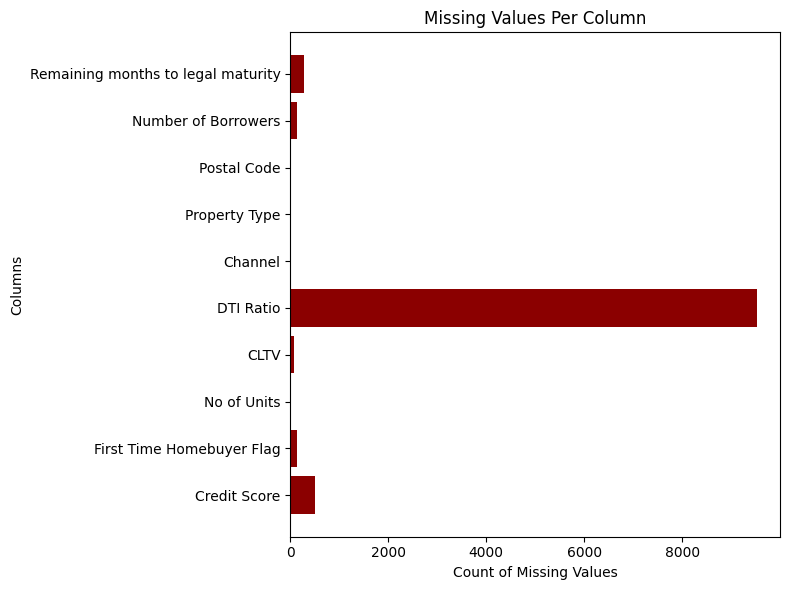

Number of missing values (zeros) before cleaning:
 10681
Missing values per column after cleaning:
Loan Seq Number                       0
Credit Score                          0
First Time Homebuyer Flag             0
No of Units                           0
Occupancy Status                      0
CLTV                                  0
DTI Ratio                             0
Ori UPB                               0
Ori Interest Rate                     0
Channel                               0
Amortization Type                     0
Property State                        0
Property Type                         0
Postal Code                           0
Loan Purpose                          0
Ori Loan Term                         0
Number of Borrowers                   0
Servicer Name                         0
I/O Indicator                         0
MI Cancellation Indicator             0
Current actual UPB                    0
Current loan delinquency status       0
Loan age             

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s finished


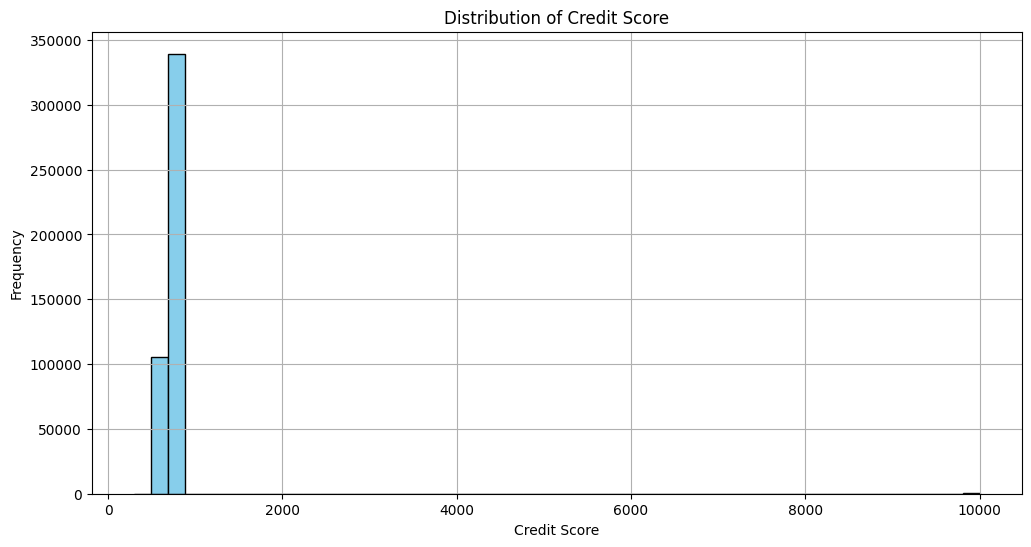

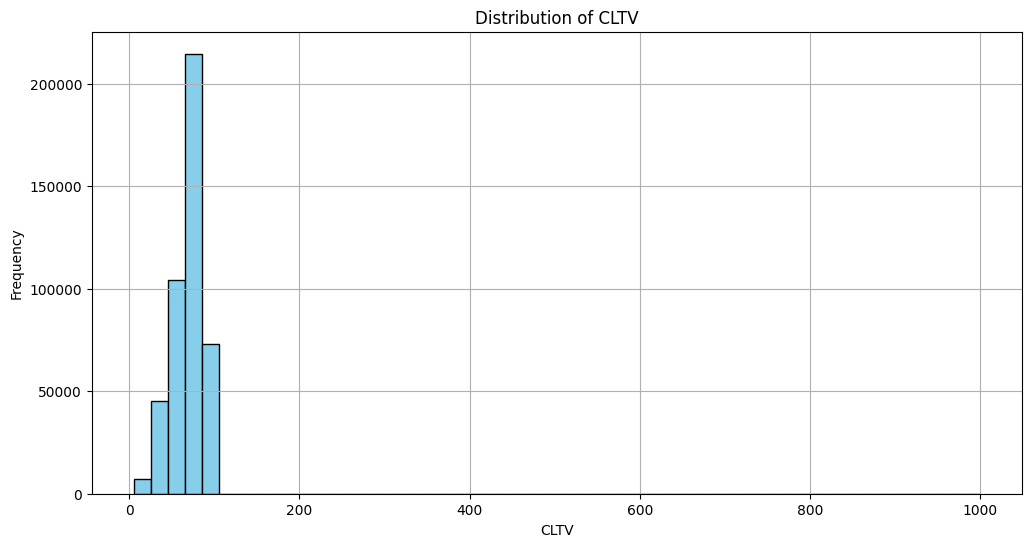

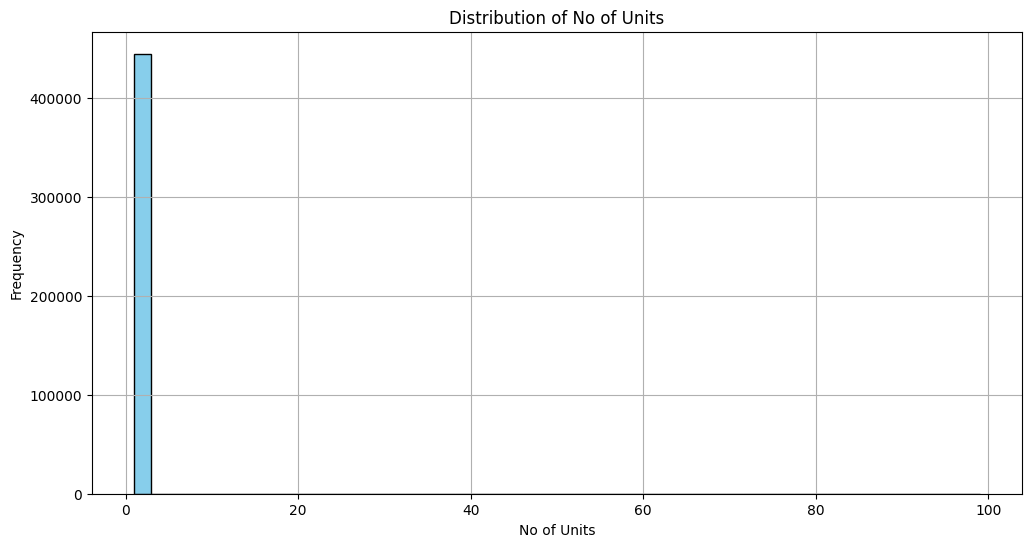

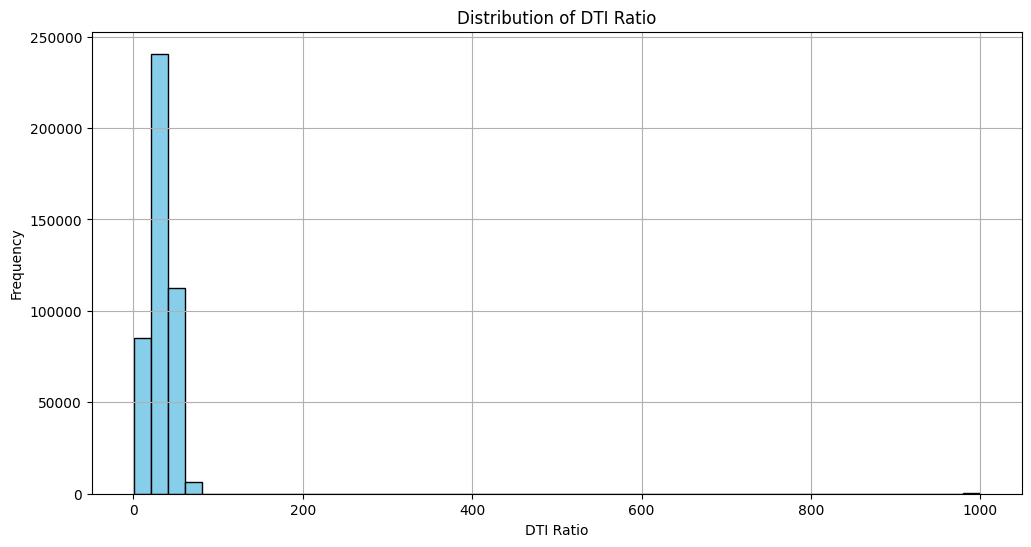

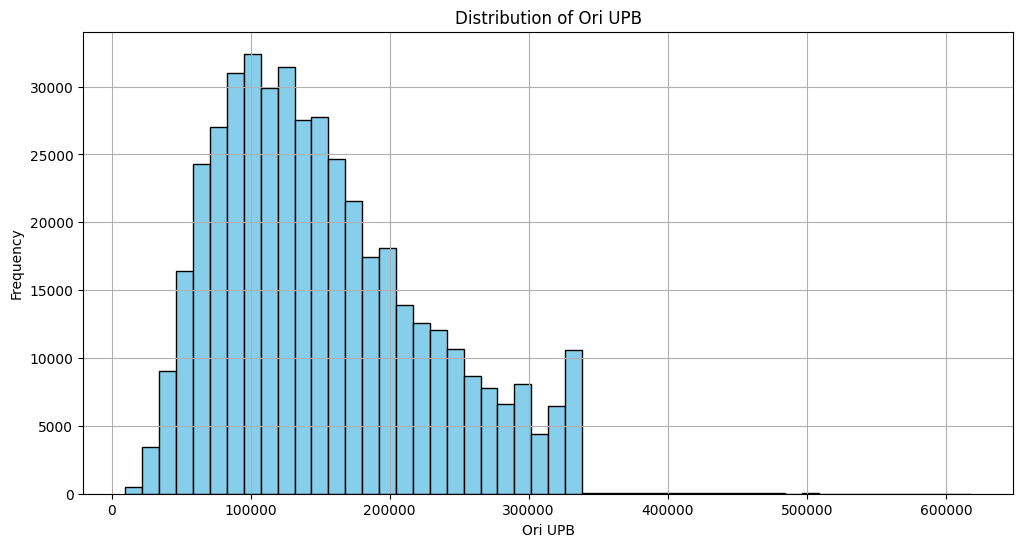

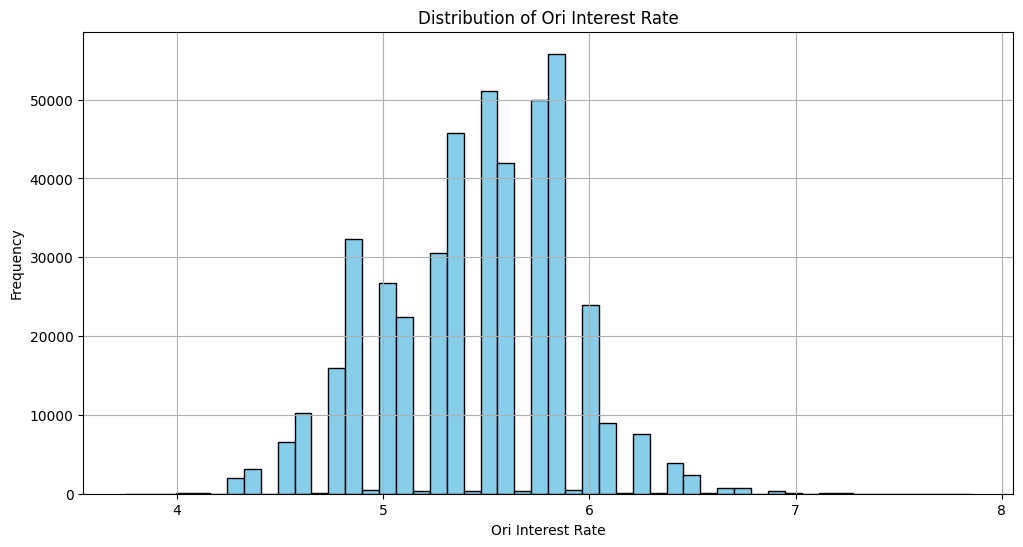

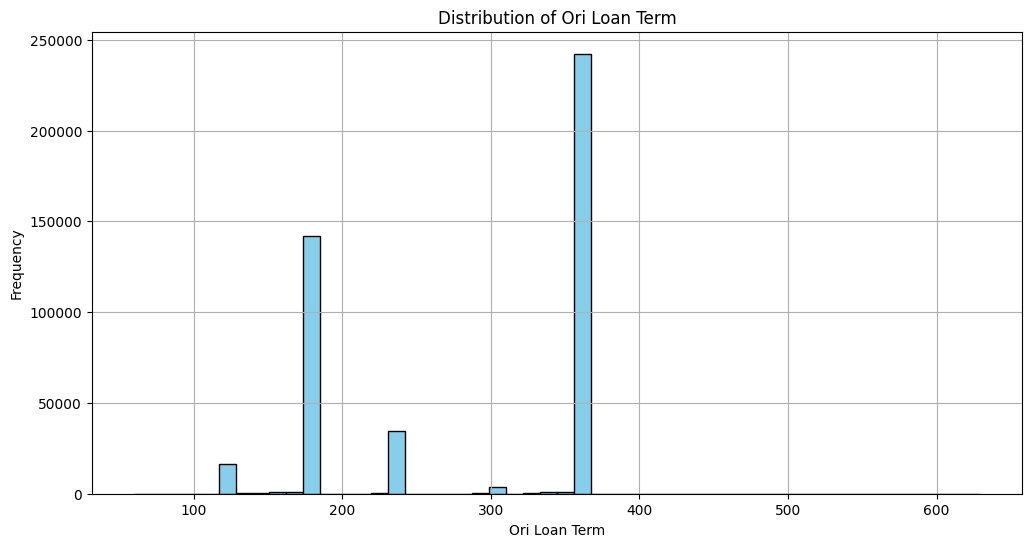

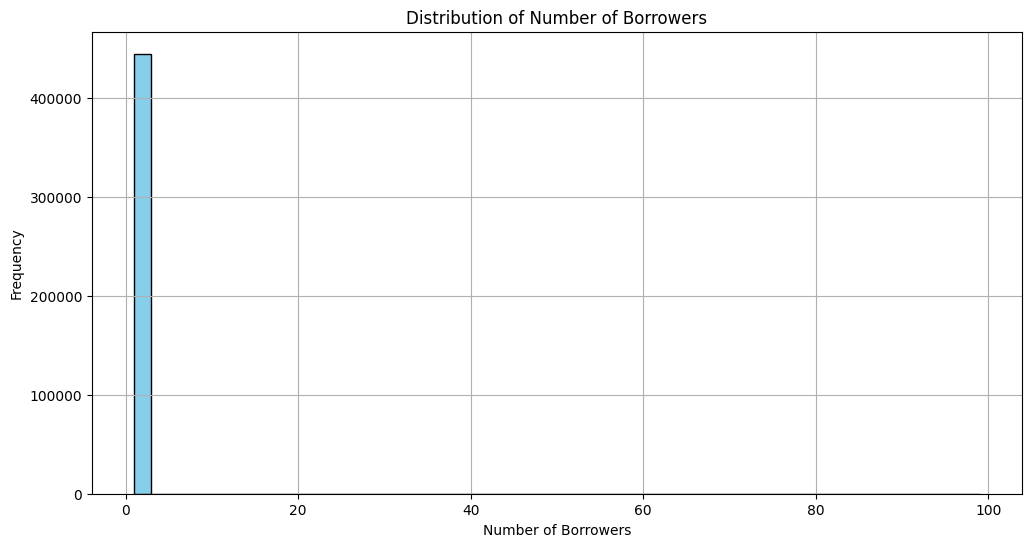

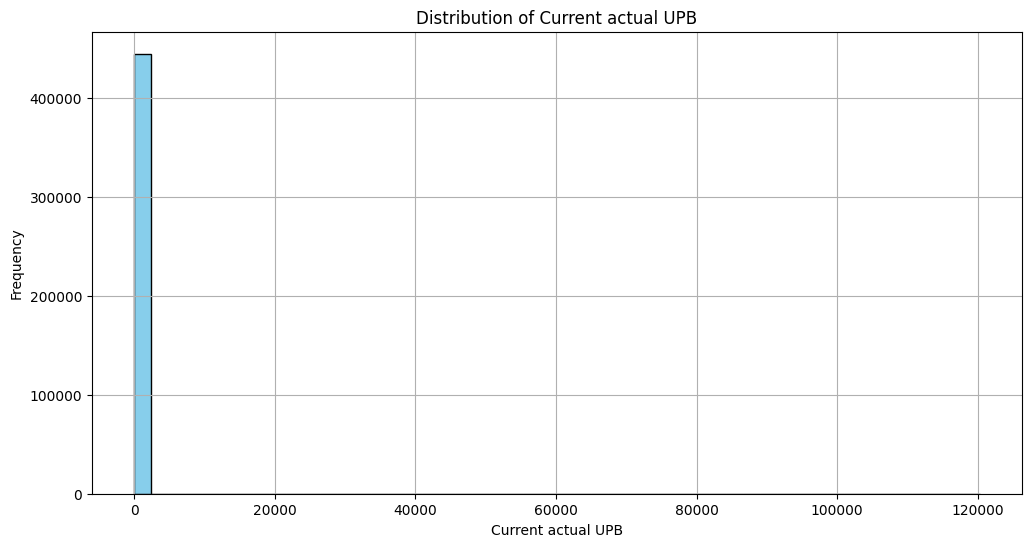

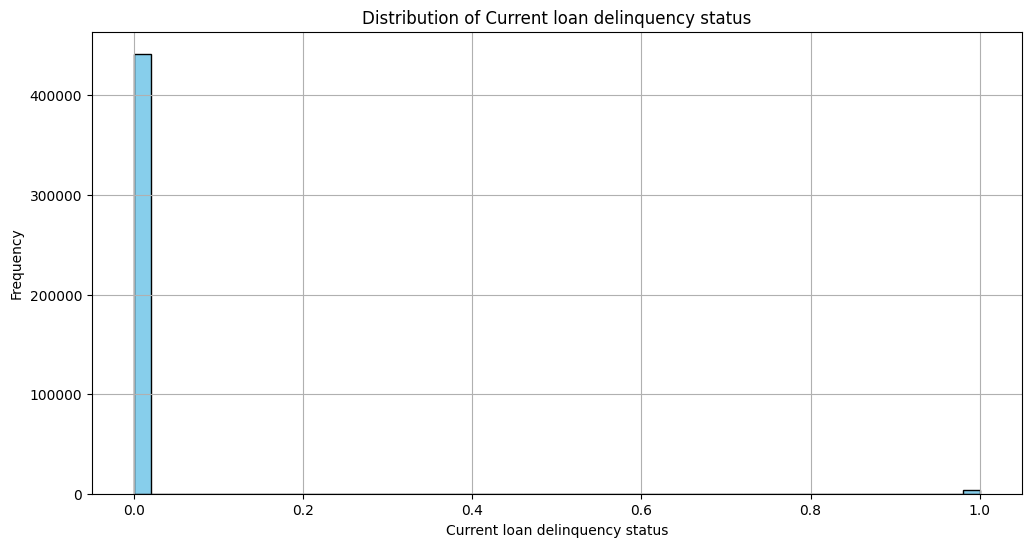

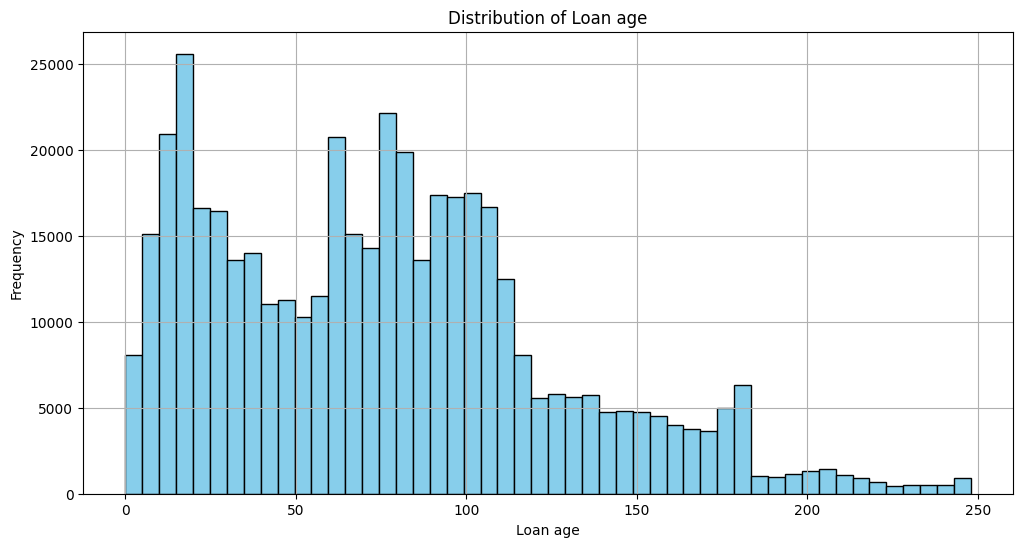

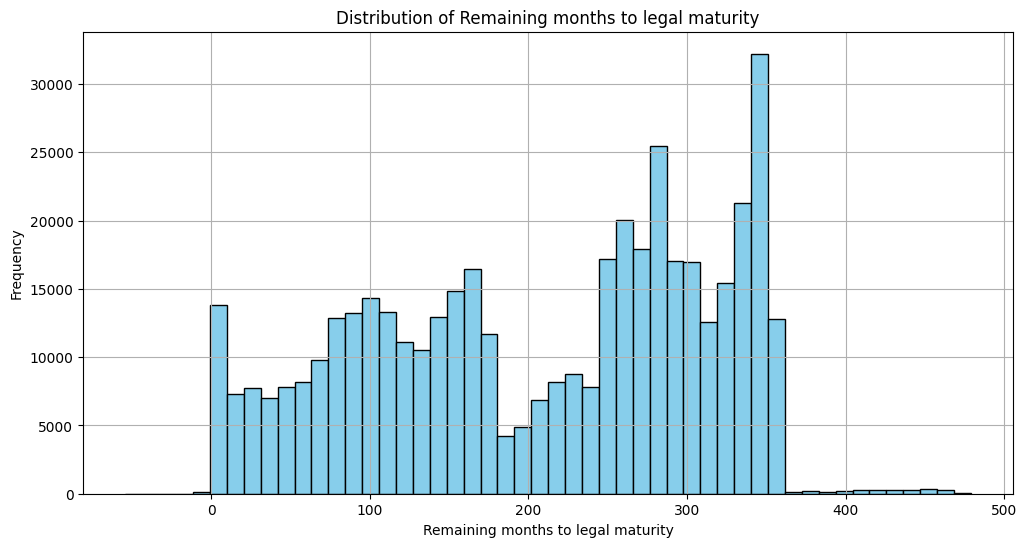

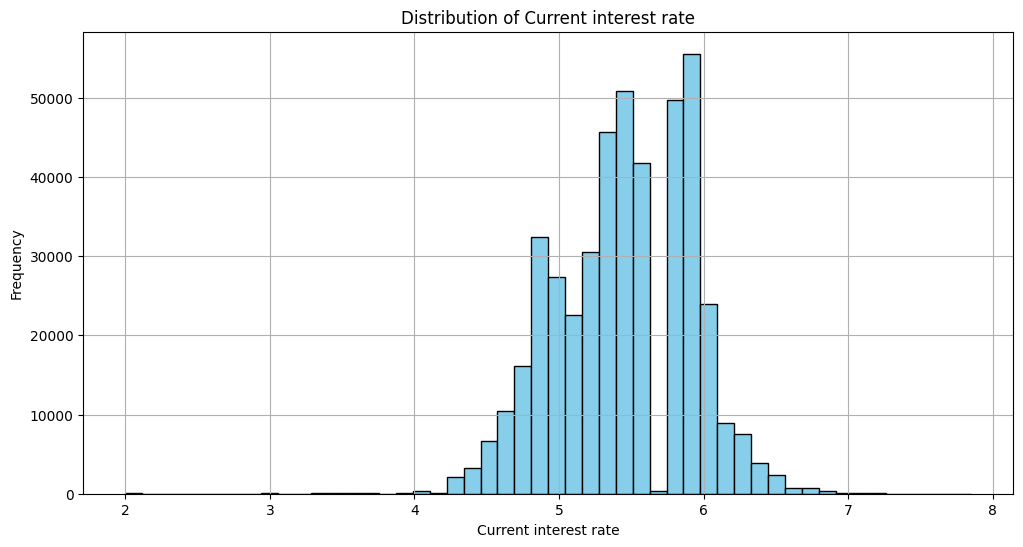

 Current working directory: /mnt/batch/tasks/shared/LS_root/mounts/clusters/khizarrouf2/code/Users/khizarrouf


In [5]:
# Start of the execution flow

# Load the configuration
config = load_config("config.yaml")

# Connect to Azure Blob Storage
container_client = connect_to_azure_datastore(config)

# Process data from blob storage and merge datasets
merged_df = merge_data(container_client, config)

# Load extra conditions
extra_conditions = load_extra_conditions(config)

# Create missing data mask
missing_data_mask = detect_missing_values(merged_df, extra_conditions=extra_conditions)
plot_missing_data(missing_data_mask)
print("Number of missing values (zeros) before cleaning:\n", missing_data_mask.sum().sum())

# Keep the original mask for training; create a copy for updating
original_missing_data_mask = missing_data_mask.copy()
updated_missing_data_mask = missing_data_mask.copy()

# Apply cleaning on a specific column or loop through columns
for column in merged_df.columns:
    merged_df = clean_column_using_mask(merged_df, column, updated_missing_data_mask, config=config)
print("Missing values per column after cleaning:")
print(merged_df.isnull().sum())

# Append missing value mask to the dataframe
# Add suffix to avoid column name conflicts
missing_data_mask_renamed = missing_data_mask.add_suffix("_missing")
# Ensure index alignment and append
merged_df = merged_df.join(missing_data_mask_renamed)

# Apply one hot encoding
merged_df = apply_one_hot_encoding(merged_df)

# Apply binarization
merged_df['Current loan delinquency status'] = merged_df['Current loan delinquency status'].apply(
    lambda x: 1 if (
        str(x).strip().lower() == config['loan_delinquency_indicator'].lower() or
        (str(x).replace('.', '', 1).isdigit() and float(x) > config['loan_delinquency_threshold'])
    ) else 0
)

# Detect and plot outliers
merged_df_OD, df_wo_outliers = detect_and_plot_outliers(merged_df, config_path="config.yaml", contamination=0.001)

# Data quality check
visualize_and_check_data(df_wo_outliers, columns=config["columns"]["anomaly_detection"])

# Normalize anomaly detection columns
normalizer = MinMaxScaler()
anomaly_cols = config["columns"]["anomaly_detection"]
df_wo_outliers[anomaly_cols] = normalizer.fit_transform(df_wo_outliers[anomaly_cols])

# Drop identifier column
df_wo_outliers = df_wo_outliers.drop(columns='Loan Seq Number')

# Create label dataframe with flipped values
label_df = df_wo_outliers[['Current loan delinquency status']]

# Drop label column from the feature dataframe
feature_df = df_wo_outliers.drop(columns=['Current loan delinquency status'])

# Print current working directory for confirmation
print(f" Current working directory: {os.getcwd()}")

# Write features and labels to Excel in the current directory (same as notebook)
input_output_files = [
    ('feature_file.xlsx', feature_df),
    ('label_file.xlsx', label_df)
]

for file_name, data_frame in input_output_files:
    data_frame.to_excel(file_name, index=False)

In [ ]:
# Get unique values for each column in merged_df
unique_values = merged_df.apply(pd.Series.unique)

# Print the unique values for each column along with the column position
for idx, (column, values) in enumerate(unique_values.items()):
    print(f"Column position {idx} - Unique values in column '{column}': {values}")


